In [1]:
import os
%pylab inline
import numpy as np
import hashlib

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os 
import hashlib
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

2024-09-03 13:23:10.236950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 13:23:10.333486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-03 13:23:10.333504: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-03 13:23:10.805417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

## Read training data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [3]:
"""Loadning training split"""
start_window = 0
end_window = 770
data_dir = "../data/malab_05282024/npz/"
assert os.path.exists(f"{data_dir}/0528_X_train_{start_window}_{end_window}.npy"), "File does not exist "

x_train_path = os.path.join(data_dir, f'0528_X_train_{start_window}_{end_window}.npy')
y_train_path = os.path.join(data_dir, f'0528_y_train_{start_window}_{end_window}.npy')

data_X = np.load(x_train_path)
data_Y = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(data_X).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(data_Y).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

print("Train Data Set:")
print("\tX Path        :", x_train_path)
print("\ty Path        :", y_train_path)
print("\tSize          :", len(data_X))
print("\tSample Shape  :", data_X[0].shape)
print("\tMean          :", data_X.mean())
print("\tStd. Dev.     :", data_X.std())

assert len(data_X[0]) == (end_window-start_window)*2, "ERROR: Specified window does not match loaded dataset shape"

Train Data Set:
	X Path        : ../data/malab_05282024/npz/0528_X_train_0_770.npy
	y Path        : ../data/malab_05282024/npz/0528_y_train_0_770.npy
	Size          : 900000
	Sample Shape  : (1540,)
	Mean          : 57.37779754545455
	Std. Dev.     : 844.0956096913322


In [4]:
data_X.shape

(900000, 1540)

In [5]:
data_Y.shape

(900000,)

In [6]:
data_Y.reshape(90,2,5000)[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Reshape training data

In [7]:
# index = [file_index, state_index, shot_index, time_index, ADC_index]
data_X_new = data_X.reshape(90, 2, 5000, 770, 2)
data_Y_new = data_Y.reshape(90, 2, 5000)

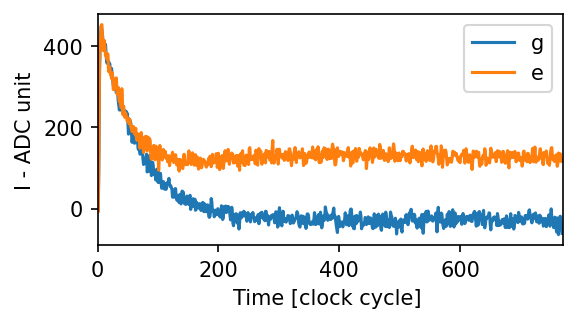

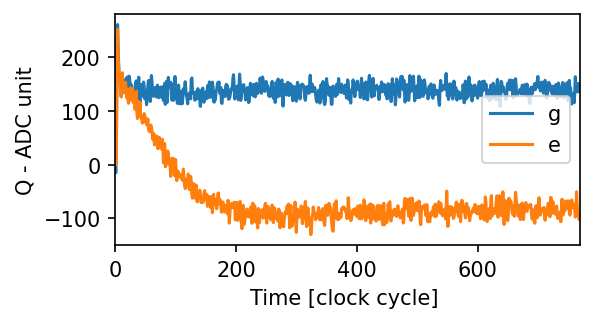

In [8]:
file_index = 0

#### I part ###
figure(figsize = (4,2), dpi = 150)


test = data_X_new[file_index,0].mean(axis = 0)
plot(test[:,0], label = 'g')
test = data_X_new[file_index,1].mean(axis = 0)
plot(test[:,0], label = 'e')
legend()

ylabel('I - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()


#### Q part ###
figure(figsize = (4,2), dpi = 150)


test = data_X_new[file_index,0].mean(axis = 0)
plot(test[:,1], label = 'g')
test = data_X_new[file_index,1].mean(axis = 0)
plot(test[:,1], label = 'e')
legend()

ylabel('Q - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()

## Read test data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [9]:
"""Loading testing split"""
start_window = 0
end_window = 770
data_dir = "../data/malab_05282024/npz/"
assert os.path.exists(f"{data_dir}/X_test_{start_window}_{end_window}.npy"), "File does not exist "

x_test_path = os.path.join(data_dir, f'0528_X_test_{start_window}_{end_window}.npy')
y_test_path = os.path.join(data_dir, f'0528_y_test_{start_window}_{end_window}.npy')

test_X = np.load(x_test_path)
test_Y = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(test_X).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(test_Y).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

print("Test Data Set:")
print("\tX Path        :", x_test_path)
print("\ty Path        :", y_test_path)
print("\tSize         :", len(test_X))
print("\tSample Shape :", test_X[0].shape)
print("\tSample Shape :", test_X.mean())
print("\tStd. Dev.    :", test_X.std())

assert len(test_X[0]) == (end_window-start_window)*2, "ERROR: Specified window does not match loaded dataset shape"

Test Data Set:
	X Path        : ../data/malab_05282024/npz/0528_X_test_0_770.npy
	y Path        : ../data/malab_05282024/npz/0528_y_test_0_770.npy
	Size         : 100000
	Sample Shape : (1540,)
	Sample Shape : 57.57549828571429
	Std. Dev.    : 845.6158899866076


In [10]:
test_X.shape

(100000, 1540)

In [11]:
test_Y.shape

(100000,)

## Reshape test data

In [12]:
# index = [file_index, state_index, shot_index, time_index, ADC_index]
test_X_new = test_X.reshape(10, 2, 5000, 770, 2)
test_Y_new = test_Y.reshape(10, 2, 5000)

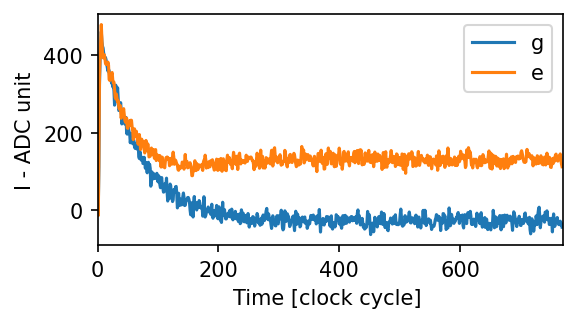

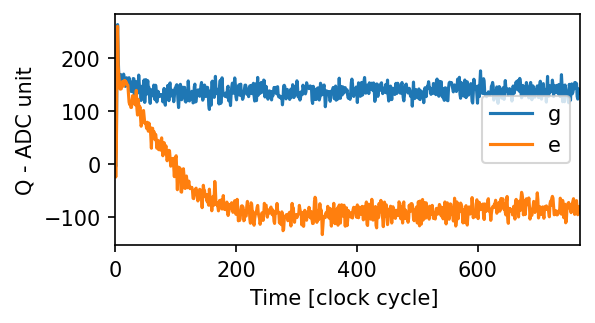

In [13]:
file_index = 0

#### I part ###
figure(figsize = (4,2), dpi = 150)


test = test_X_new[file_index,0].mean(axis = 0)
plot(test[:,0], label = 'g')
test = test_X_new[file_index,1].mean(axis = 0)
plot(test[:,0], label = 'e')
legend()

ylabel('I - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()


#### Q part ###
figure(figsize = (4,2), dpi = 150)


test = test_X_new[file_index,0].mean(axis = 0)
plot(test[:,1], label = 'g')
test = test_X_new[file_index,1].mean(axis = 0)
plot(test[:,1], label = 'e')
legend()

ylabel('Q - ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()

## TH model

In [14]:
readout_loc_list = np.linspace(0,350, 8)
all_fidelity = np.zeros(len(readout_loc_list))
all_fidelity_train = np.zeros(len(readout_loc_list))

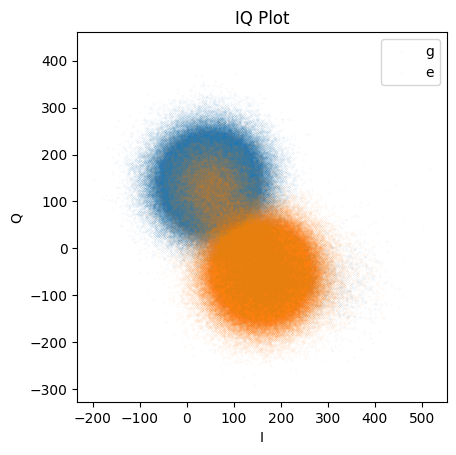

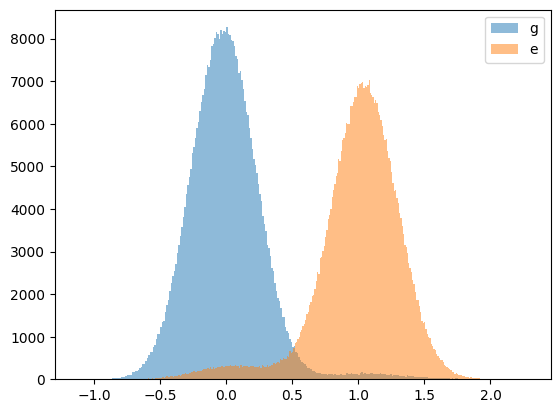

max fidelity =  0.9069

 rough estimation of n_th


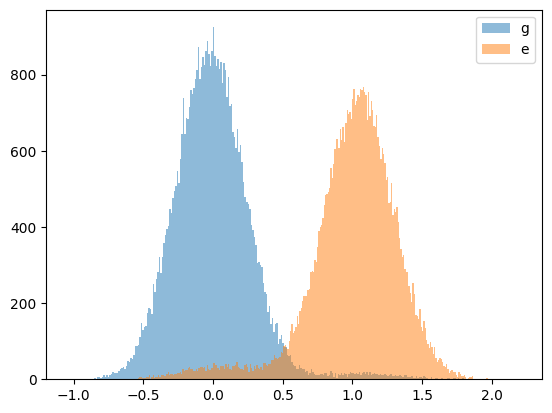

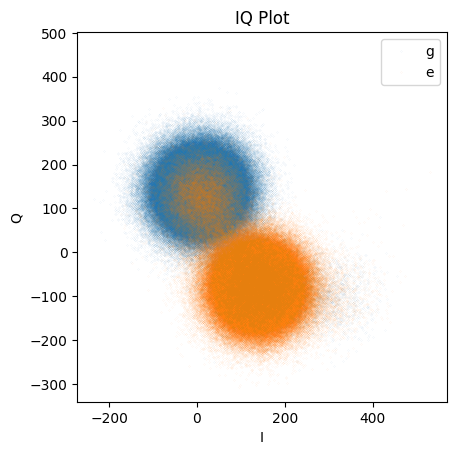

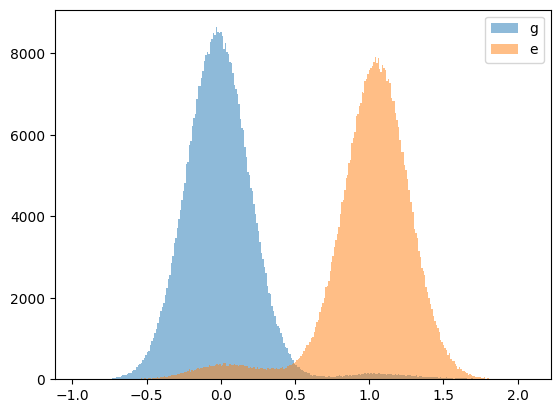

max fidelity =  0.919748888888889

 rough estimation of n_th


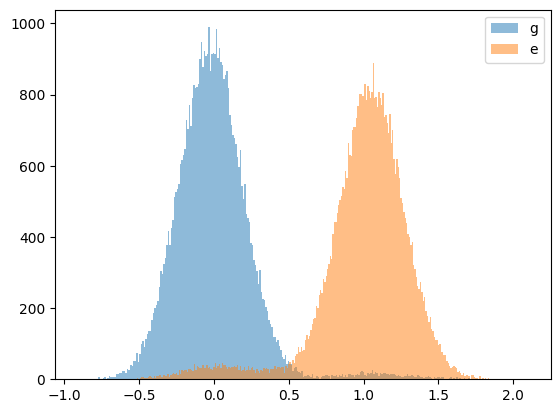

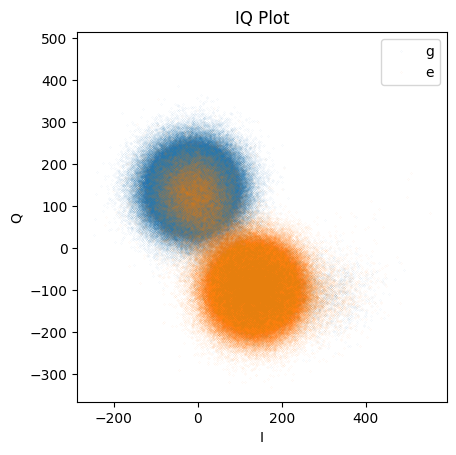

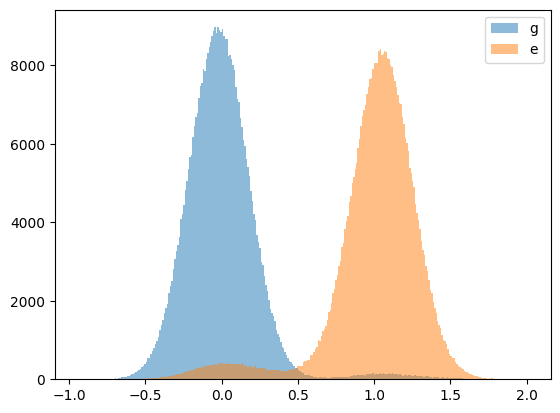

max fidelity =  0.9208822222222222

 rough estimation of n_th


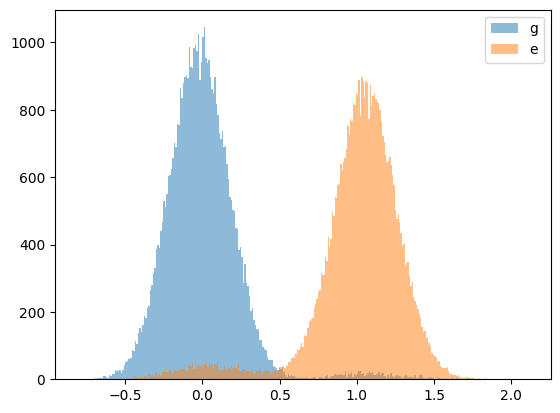

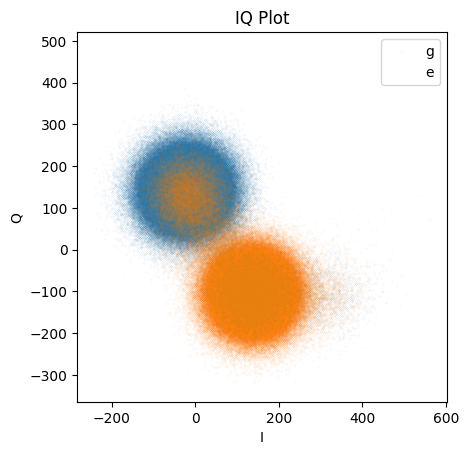

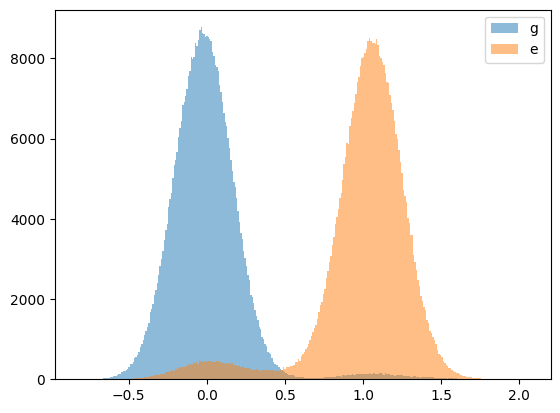

max fidelity =  0.9178711111111111

 rough estimation of n_th


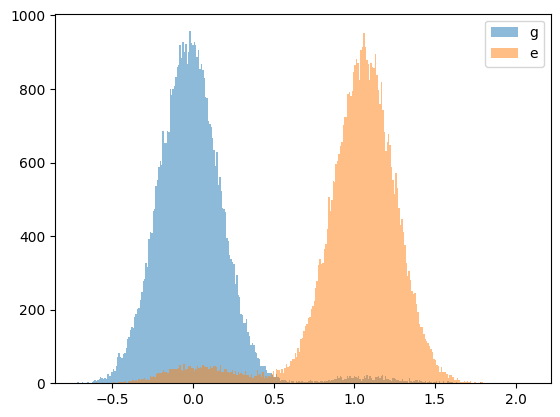

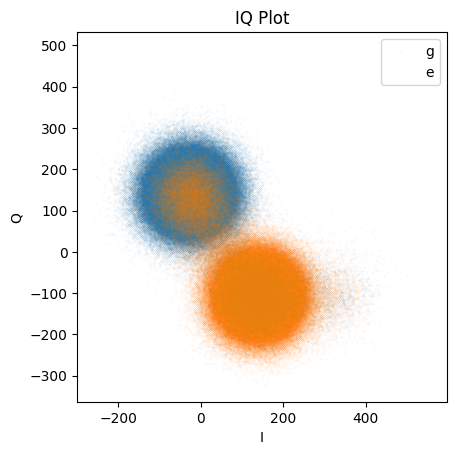

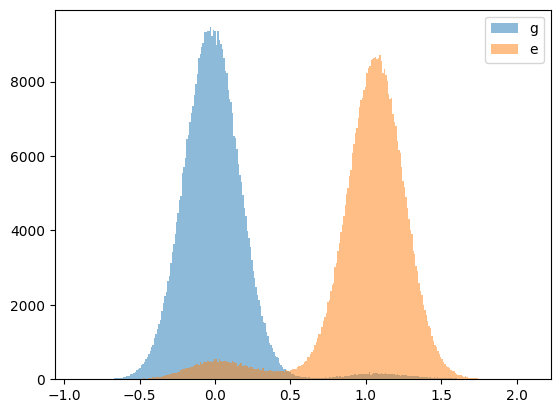

max fidelity =  0.9130866666666666

 rough estimation of n_th


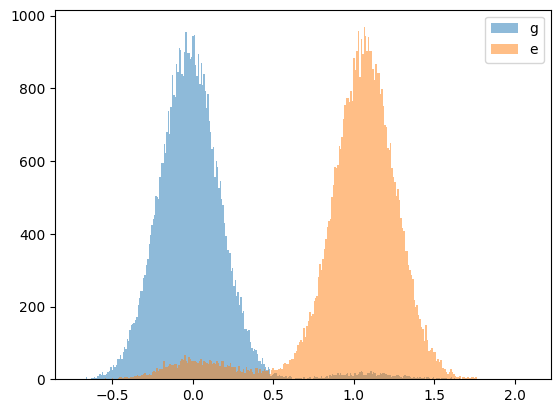

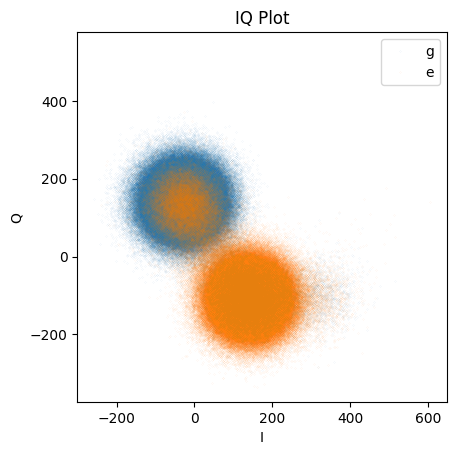

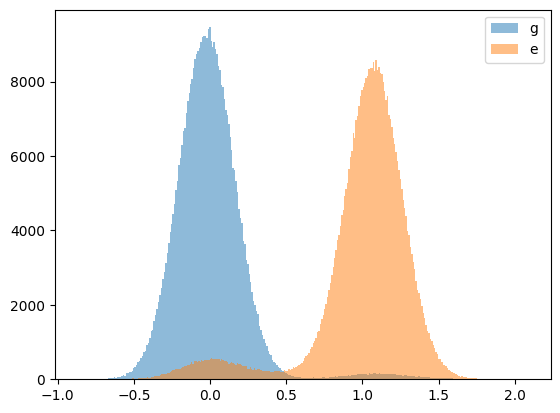

max fidelity =  0.9080822222222222

 rough estimation of n_th


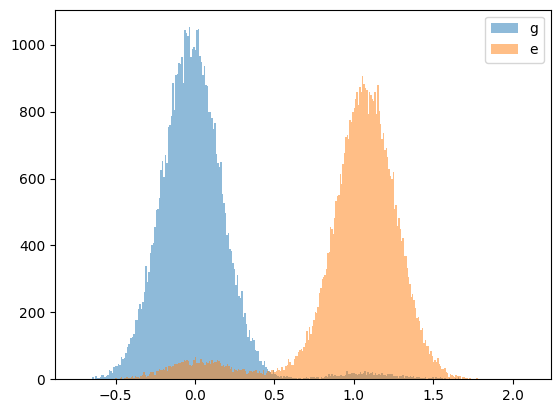

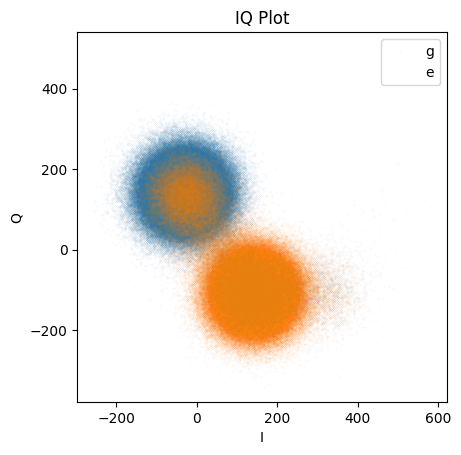

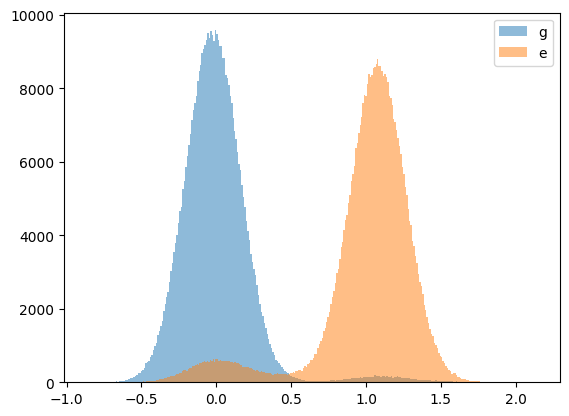

max fidelity =  0.9025155555555555

 rough estimation of n_th


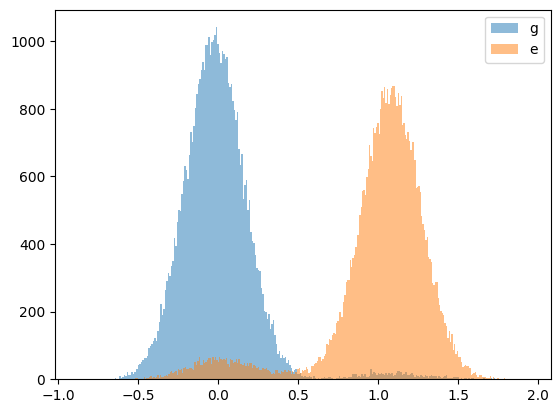

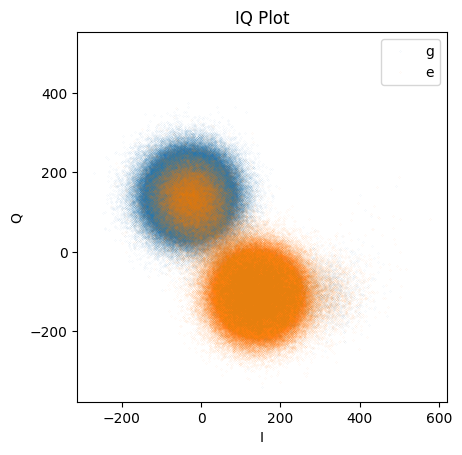

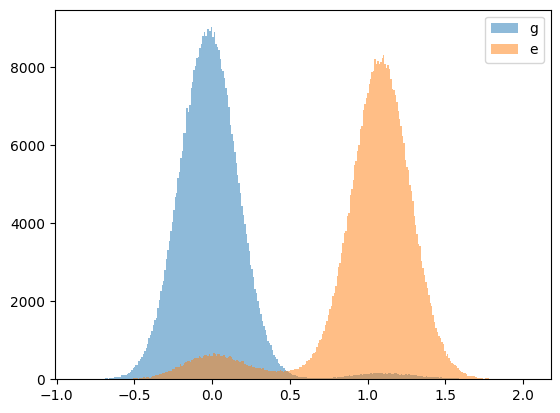

max fidelity =  0.8970733333333334

 rough estimation of n_th


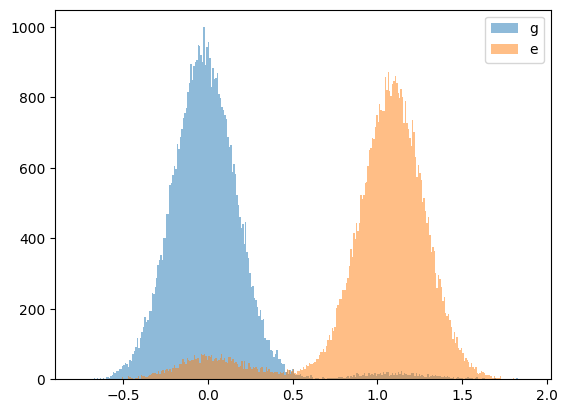

In [15]:
for m, readout_loc in enumerate(readout_loc_list):
    #### training data #####
    if True:
        mean_Ig_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 0].mean(axis = 2)
        mean_Qg_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 1].mean(axis = 2)
        mean_Ie_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 0].mean(axis = 2)
        mean_Qe_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 1].mean(axis = 2)

        # IQ plot
        I_g = mean_Ig_train.flatten()
        Q_g = mean_Qg_train.flatten()
        I_e = mean_Ie_train.flatten()
        Q_e = mean_Qe_train.flatten()

        plt.title('IQ Plot')
        plt.plot(I_g, Q_g, '.',label = 'g',markersize = 0.05)
        plt.plot(I_e, Q_e, '.',label = 'e',markersize = 0.05)
        plt.xlabel('I')
        plt.ylabel('Q')
        plt.legend()
        plt.axis('square')
        show()

        Ig = mean(I_g)
        Ie = mean(I_e)
        Qg = mean(Q_g)
        Qe = mean(Q_e)
        vec_I = Ie - Ig
        vec_Q = Qe - Qg

        gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
        estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2
        plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
        plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
        plt.legend()
        show()

        th_min = min(gstate)
        th_max = max(estate)
        th_list = np.linspace(th_min,th_max,1000)

        fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
        print('max fidelity = ',max(fidelity)*2-1)
        loc_opt = argmax(fidelity)

        print('\n rough estimation of n_th')
        100*sum(gstate>th_list[argmax(fidelity)])/len(gstate)
        
        all_fidelity_train[m] = max(fidelity)*2-1
    
    #### testing data #####
    if True:
        mean_Ig_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 0].mean(axis = 2)
        mean_Qg_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 1].mean(axis = 2)
        mean_Ie_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 0].mean(axis = 2)
        mean_Qe_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 1].mean(axis = 2)

        # IQ plot
        I_g = mean_Ig_test.flatten()
        Q_g = mean_Qg_test.flatten()
        I_e = mean_Ie_test.flatten()
        Q_e = mean_Qe_test.flatten()
        
        gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
        estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2
        plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
        plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
        plt.legend()
        show()
        
        th = th_list[loc_opt]
        test_fide = (sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2

        all_fidelity[m] = test_fide*2-1

Text(0, 0.5, 'Flidelity')

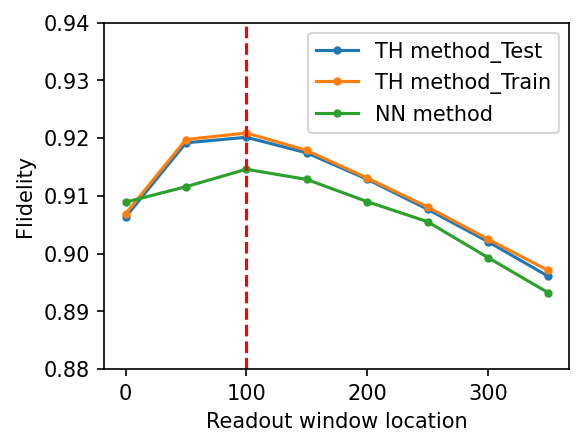

In [16]:
all_fidelity_NN = np.array([0.95445, 0.95579, 0.9573, 0.95642, 0.9545, 0.95276, 0.94966, 0.94661])

figure(figsize = (4,3), dpi = 150)
# errorbar(readout_loc_list, all_fidelity, xerr=0.0, yerr=all_fidelity_std,  label = 'TH method')
plot(readout_loc_list, all_fidelity, '.-', label = 'TH method_Test')
plot(readout_loc_list, all_fidelity_train, '.-', label = 'TH method_Train')
plot(readout_loc_list, all_fidelity_NN*2-1, '.-', label = 'NN method')

axvline(100, ls = '--', color = 'red')
legend()
ylim(0.88,0.94)
xlabel('Readout window location')
ylabel('Flidelity')

## MF model

In [17]:
# index = [file_index, state_index, shot_index, time_index, ADC_index]
data_X_new = data_X.reshape(90, 2, 5000, 770, 2)
data_Y_new = data_Y.reshape(90, 2, 5000)

In [18]:
mean_Ig_trace = (data_X_new[:,0,:,:,0].mean(axis = 0)).mean(axis = 0)
mean_Qg_trace = (data_X_new[:,0,:,:,1].mean(axis = 0)).mean(axis = 0)
mean_Ie_trace = (data_X_new[:,1,:,:,0].mean(axis = 0)).mean(axis = 0)
mean_Qe_trace = (data_X_new[:,1,:,:,1].mean(axis = 0)).mean(axis = 0)

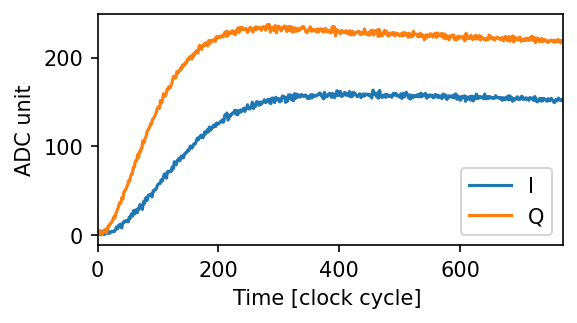

In [19]:
weight_I = abs(mean_Ig_trace - mean_Ie_trace)
weight_Q = abs(mean_Qg_trace - mean_Qe_trace)

figure(figsize = (4,2), dpi = 150)
plot(weight_I, label = 'I', color = 'C0', ls = '-')
plot(weight_Q, label = 'Q', color = 'C1', ls = '-')
ylabel('ADC unit')
xlabel('Time [clock cycle] ')
xlim(0,770)
legend()
show()

In [20]:
readout_loc_list = np.linspace(0,350, 8)
all_fidelity_MF_train = np.zeros(len(readout_loc_list))
all_fidelity_MF_test = np.zeros(len(readout_loc_list))

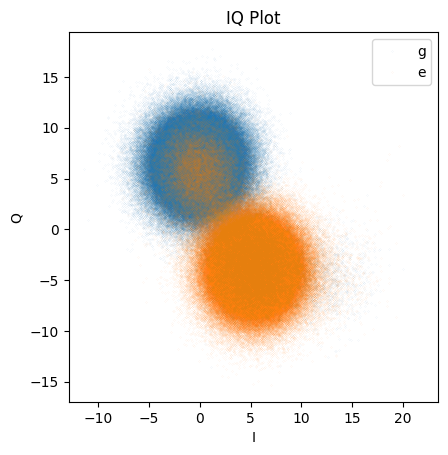

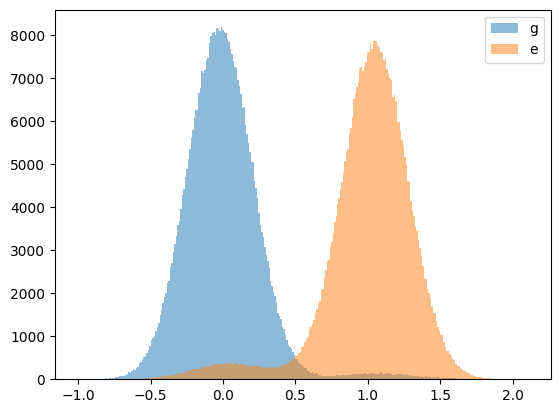

max fidelity =  0.9159666666666666

 rough estimation of n_th


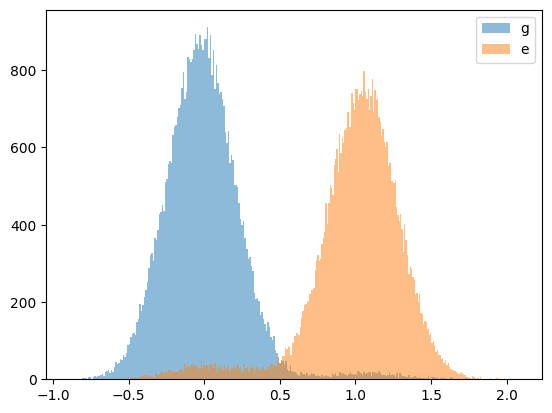

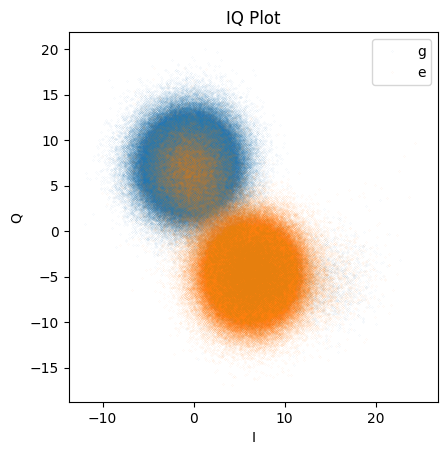

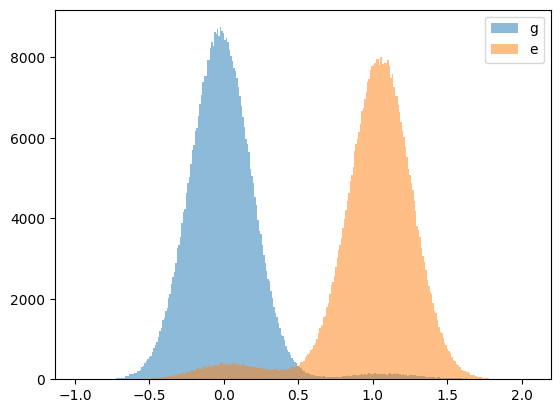

max fidelity =  0.9199133333333334

 rough estimation of n_th


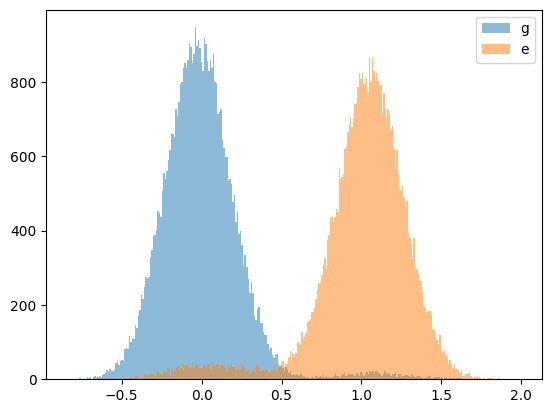

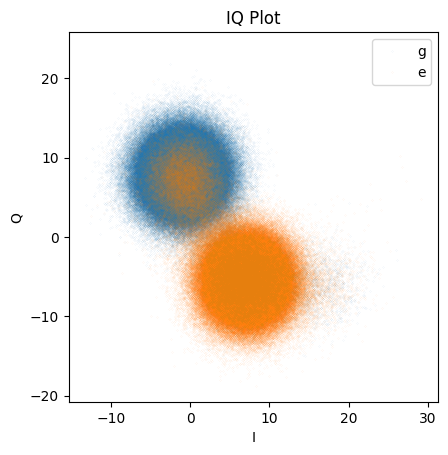

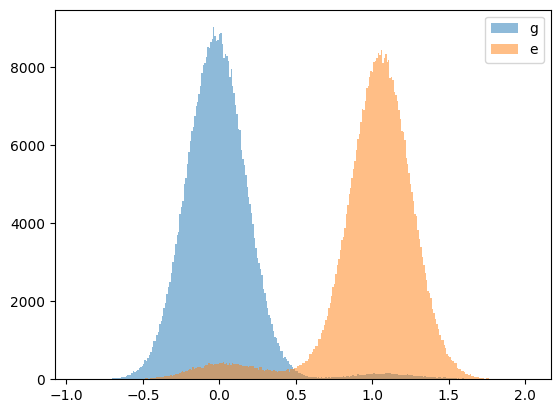

max fidelity =  0.9202955555555556

 rough estimation of n_th


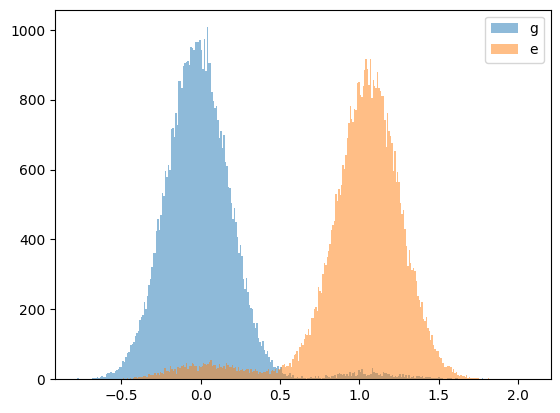

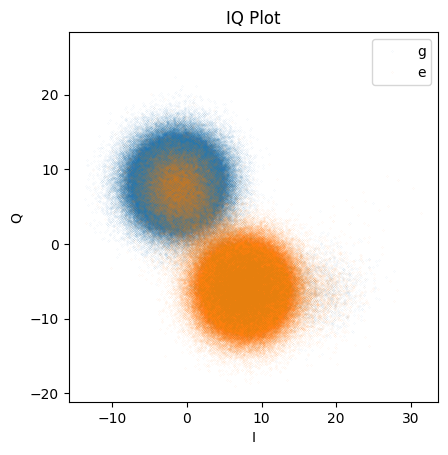

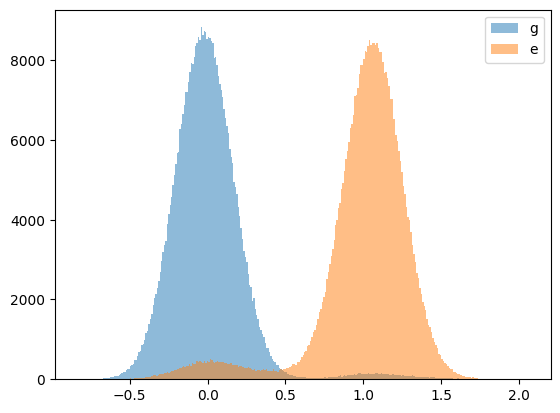

max fidelity =  0.917491111111111

 rough estimation of n_th


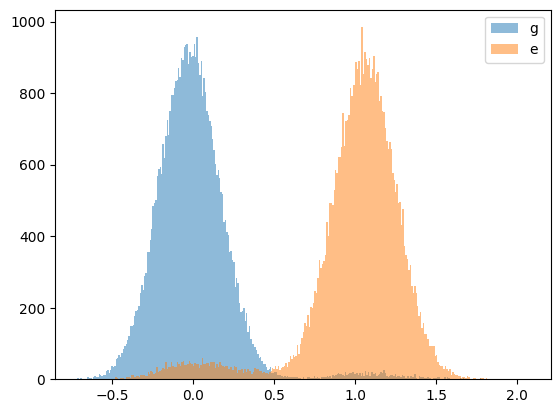

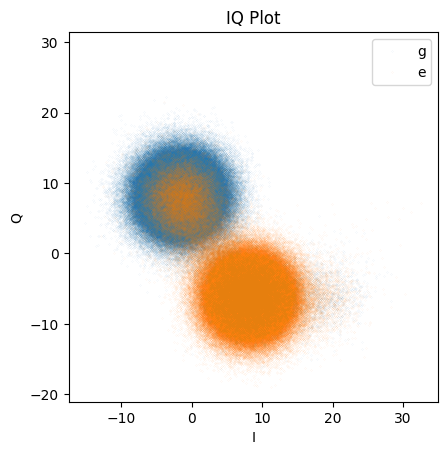

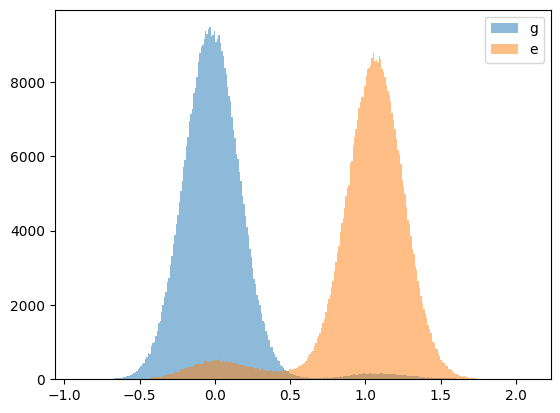

max fidelity =  0.9130466666666666

 rough estimation of n_th


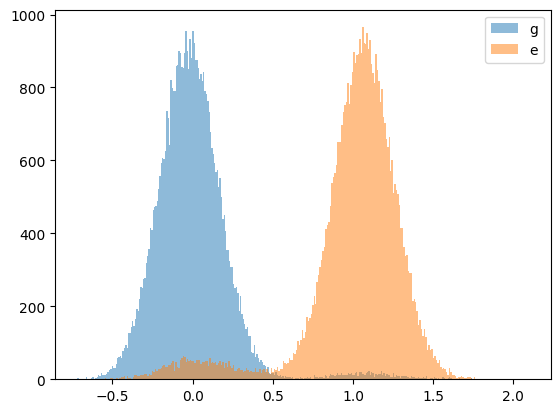

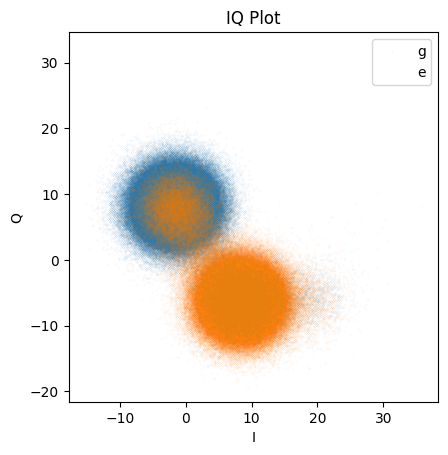

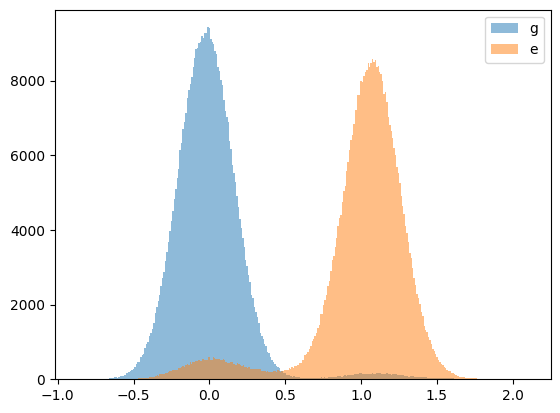

max fidelity =  0.9081933333333334

 rough estimation of n_th


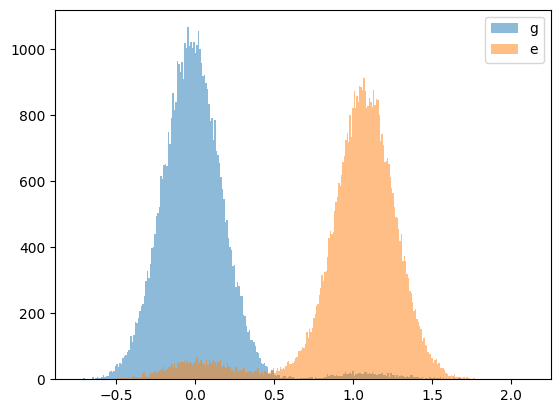

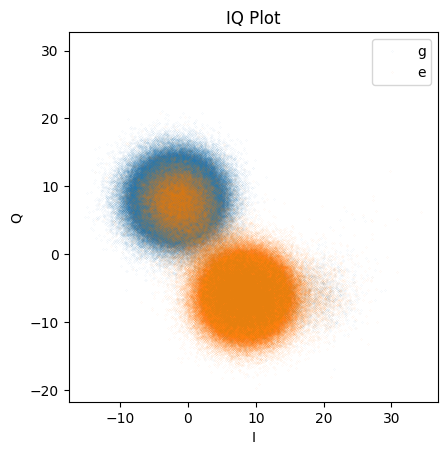

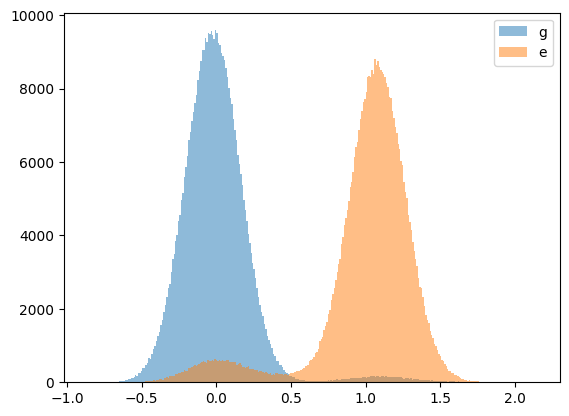

max fidelity =  0.9026755555555555

 rough estimation of n_th


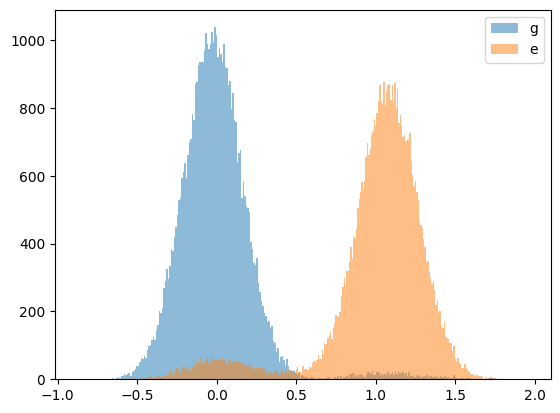

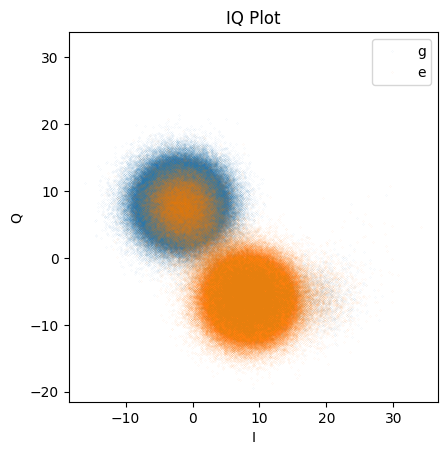

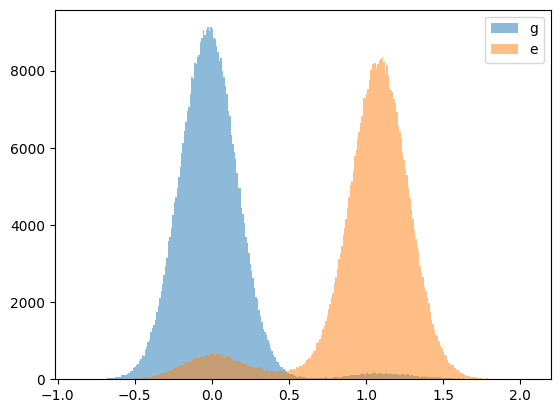

max fidelity =  0.8972933333333333

 rough estimation of n_th


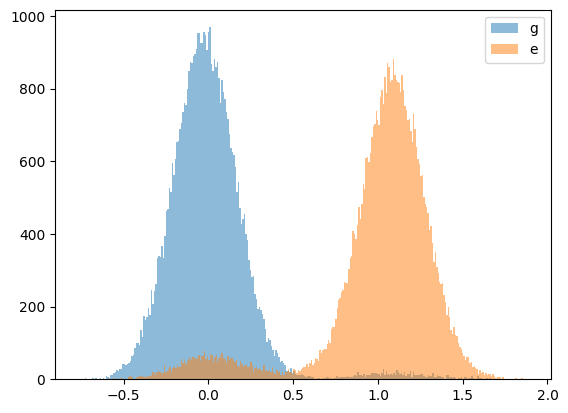

In [21]:
for m, readout_loc in enumerate(readout_loc_list):
    #### training data #####
    if True:
        mean_Ig_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 0].dot(weight_I[int(readout_loc):int(readout_loc + 400)])
        mean_Qg_train = data_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 1].dot(weight_Q[int(readout_loc):int(readout_loc + 400)])
        mean_Ie_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 0].dot(weight_I[int(readout_loc):int(readout_loc + 400)])
        mean_Qe_train = data_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 1].dot(weight_Q[int(readout_loc):int(readout_loc + 400)])

        # IQ plot  
        ratio = 1.5
        I_g = ratio*mean_Ig_train.flatten()/770/2048
        Q_g = mean_Qg_train.flatten()/770/2048
        I_e = ratio*mean_Ie_train.flatten()/770/2048
        Q_e = mean_Qe_train.flatten()/770/2048

        plt.title('IQ Plot')
        plt.plot(I_g, Q_g, '.',label = 'g',markersize = 0.05)
        plt.plot(I_e, Q_e, '.',label = 'e',markersize = 0.05)
        plt.xlabel('I')
        plt.ylabel('Q')
        plt.legend()
        plt.axis('square')
        show()

        Ig = mean(I_g)
        Ie = mean(I_e)
        Qg = mean(Q_g)
        Qe = mean(Q_e)
        vec_I = Ie - Ig
        vec_Q = Qe - Qg

        gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
        estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2
        plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
        plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
        plt.legend()
        show()

        th_min = min(gstate)
        th_max = max(estate)
        th_list = np.linspace(th_min,th_max,1000)

        fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
        print('max fidelity = ',max(fidelity)*2-1)
        loc_opt = argmax(fidelity)

        print('\n rough estimation of n_th')
        100*sum(gstate>th_list[argmax(fidelity)])/len(gstate)
        
        all_fidelity_MF_train[m] = max(fidelity)*2-1
    
    #### testing data #####
    if True:
        mean_Ig_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 0].dot(weight_I[int(readout_loc):int(readout_loc + 400)])
        mean_Qg_test = test_X_new[:, 0, :, int(readout_loc): int(readout_loc + 400), 1].dot(weight_Q[int(readout_loc):int(readout_loc + 400)])
        mean_Ie_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 0].dot(weight_I[int(readout_loc):int(readout_loc + 400)])
        mean_Qe_test = test_X_new[:, 1, :, int(readout_loc): int(readout_loc + 400), 1].dot(weight_Q[int(readout_loc):int(readout_loc + 400)])

        # IQ plot
        ratio = 1.5
        I_g = ratio*mean_Ig_test.flatten()/770/2048
        Q_g = mean_Qg_test.flatten()/770/2048
        I_e = ratio*mean_Ie_test.flatten()/770/2048
        Q_e = mean_Qe_test.flatten()/770/2048
        
        gstate = (I_g - Ig)*vec_I + (Q_g - Qg)*vec_Q
        estate = (I_e - Ig)*vec_I + (Q_e - Qg)*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2
        plt.hist(gstate,bins = 300,label = 'g',alpha = 0.5)
        plt.hist(estate,bins = 300,label = 'e',alpha = 0.5)
        plt.legend()
        show()
        
        th = th_list[loc_opt]
        test_fide = (sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2

        all_fidelity_MF_test[m] = test_fide*2-1

In [22]:
all_fidelity_train[:4].shape

(4,)

Text(0, 0.5, 'Flidelity')

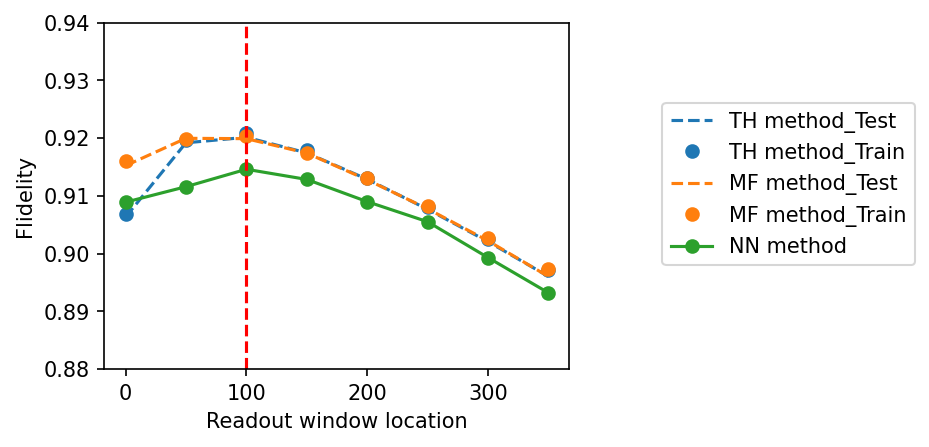

In [25]:
all_fidelity_NN = np.array([0.95445, 0.95579, 0.9573, 0.95642, 0.9545, 0.95276, 0.94966, 0.94661])

figure(figsize = (4,3), dpi = 150)
plot(readout_loc_list, all_fidelity, '--', color = 'C0', label = 'TH method_Test')
plot(readout_loc_list, all_fidelity_train, 'o', color = 'C0',label = 'TH method_Train')
plot(readout_loc_list, all_fidelity_MF_test, '--', color = 'C1', label = 'MF method_Test')
plot(readout_loc_list, all_fidelity_MF_train, 'o', color = 'C1', label = 'MF method_Train')
plot(readout_loc_list, all_fidelity_NN*2-1, 'o-', color = 'C2', label = 'NN method')

axvline(100, ls = '--', color = 'red')
legend(loc = (1.2,.3))
ylim(0.88,0.94)
xlabel('Readout window location')
ylabel('Flidelity')

In [27]:
outfile = '_FIG_EXP_train_window_loc_MF_TH_NN.npz'
note = 'Training data on 0528, readout fidelity with moving readout window, window size = 400'

np.savez(outfile, 
         readout_loc_list=readout_loc_list, 
         fidelity_NN = all_fidelity_NN*2-1, 
         fidelity_TH_train = all_fidelity_train,
         fidelity_TH_test = all_fidelity,
         fidelity_MF_train = all_fidelity_MF_train,
         fidelity_MF_test = all_fidelity_MF_test,
         note=note)

## NN model

Results are with smaller readout window (400) and the start location of the readout window (0, 50, 100, ..., 350).

In [28]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded


In [29]:
X_train_val = data_X
y_train_val = data_Y
y_train_val = one_hot_encode(y_train_val)

del data_X
del data_Y

X_test = test_X
y_test = test_Y
y_test = one_hot_encode(y_test)

del test_X
del test_Y

In [30]:
"""hyperparameters"""
init_learning_rate = 1e-4
validation_split = 0
batch_size = 8192
epochs = 50
checkpoint_filename = "multi-layer.h5"
input_shape = (len(X_train_val[0]),)
start_window = 0
end_window = 770

window_start_locations = list(range(0, 350+1, 50))
window_size = 400

In [31]:
def scan_readout_window(model, window_start_locations, window_size, callbacks):
    all_fidelity = list()
    all_accuracy = list()
    all_e_accuracy = list()
    all_g_accuracy = list()

    for start_window in window_start_locations:
        end_window = start_window + window_size

        #########################
        # 1. get readout window 
        #########################
        X_train_window = X_train_val[:,start_window*2:end_window*2]
        X_test_window = X_test[:,start_window*2:end_window*2]

        #########################
        # 2. start training 
        #########################
        opt = Adam(learning_rate=init_learning_rate)
        model.compile(
            optimizer=opt, 
            loss=CategoricalCrossentropy(from_logits=True), 
            metrics=['accuracy']
        )

        history = model.fit(
            X_train_window, 
            y_train_val, 
            batch_size=batch_size,
            epochs=50, 
            validation_split=0.05, 
            shuffle=True, 
            callbacks=callbacks,
            verbose=2
        )

        #########################
        # 3. load checkpoint 
        #########################
        co = {}
        _add_supported_quantized_objects(co)
        model = load_model(checkpoint_filename, custom_objects=co, compile=False)

        #########################
        # 4. compute fidelity 
        #########################
        y_pred = model.predict(X_test_window)
        test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        print("Keras  Accuracy: {}".format(test_acc))
        all_accuracy.append(test_acc)
        
        # get ground and excited indices 
        e_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]
        g_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]

        # separate ground and excited samples 
        Xe_test = X_test_window[e_indices]
        ye_test = np.argmax(y_test, axis=1)[e_indices]

        Xg_test = X_test_window[g_indices]
        yg_test = np.argmax(y_test, axis=1)[g_indices]

        # compute total correct for excited state 
        ye_pred = model.predict(Xe_test)
        e_accuracy = accuracy_score(ye_test, np.argmax(ye_pred, axis=1))

        total_correct = (ye_test==np.argmax(ye_pred, axis=1)).astype(np.int8).sum()
        total_incorrect = (ye_test!=np.argmax(ye_pred, axis=1)).astype(np.int8).sum()

        print("Total correct:", total_correct)
        print("Total incorrect:", total_incorrect)
        print("Total samples:", len(Xe_test) )
        print("Keras Excited Accuracy: {}".format(e_accuracy))

        # compute total correct for ground state 
        yg_pred = model.predict(Xg_test)
        g_accuracy = accuracy_score(yg_test, np.argmax(yg_pred, axis=1))

        total_correct = (yg_test==np.argmax(yg_pred, axis=1)).astype(np.int8).sum()
        total_incorrect = (yg_test!=np.argmax(yg_pred, axis=1)).astype(np.int8).sum()

        print("Total correct:", total_correct)
        print("Total incorrect:", total_incorrect)
        print("Total samples:", len(Xg_test) )
        print("Keras Ground Accuracy: {}".format(g_accuracy))

        all_e_accuracy.append(e_accuracy)
        all_g_accuracy.append(g_accuracy)

        # compute fidelity 
        fidelity = 0.5*(e_accuracy + g_accuracy)
        all_fidelity.append(fidelity)
        print('\n===================================')
        print('Fidelity', fidelity)
        print('===================================')

    return all_accuracy, all_e_accuracy, all_g_accuracy


### Large version

<img src="../images/multi_layer_model.png" alt="alt text" width="50%">

In [32]:
### calbacks 
checkpoint_filename = 'multi_layer_model_subwindow.h5'
callbacks = [
        ModelCheckpoint(
        checkpoint_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=10, min_delta=1**-6),
]


### model 
sr = int((end_window-start_window)*2)
hn = sr * 2

model = Sequential()
model.add(Dense(int(hn/8), activation='relu', input_shape=(800,), kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4),))
print(model.summary())

### scan readout window and train 
ml_accuracy, ml_e_accuracy, ml_g_accuracy  = scan_readout_window(model, window_start_locations, window_size, callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 385)               308385    
                                                                 
 batch_normalization (BatchN  (None, 385)              1540      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 772       
                                                                 
Total params: 310,697
Trainable params: 309,927
Non-trainable params: 770
_________________________________________________________________


2024-09-03 13:26:41.016442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-03 13:26:41.016701: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-03 13:26:41.016746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-09-03 13:26:41.017676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/50
105/105 - 3s - loss: 0.3743 - accuracy: 0.8773 - val_loss: 0.2647 - val_accuracy: 0.9465 - lr: 1.0000e-04 - 3s/epoch - 29ms/step
Epoch 2/50
105/105 - 2s - loss: 0.2452 - accuracy: 0.9531 - val_loss: 0.2436 - val_accuracy: 0.9516 - lr: 1.0000e-04 - 2s/epoch - 19ms/step
Epoch 3/50
105/105 - 2s - loss: 0.2340 - accuracy: 0.9553 - val_loss: 0.2342 - val_accuracy: 0.9526 - lr: 1.0000e-04 - 2s/epoch - 19ms/step
Epoch 4/50
105/105 - 2s - loss: 0.2262 - accuracy: 0.9559 - val_loss: 0.2276 - val_accuracy: 0.9528 - lr: 1.0000e-04 - 2s/epoch - 19ms/step
Epoch 5/50
105/105 - 2s - loss: 0.2197 - accuracy: 0.9564 - val_loss: 0.2225 - val_accuracy: 0.9533 - lr: 1.0000e-04 - 2s/epoch - 19ms/step
Epoch 6/50
105/105 - 2s - loss: 0.2143 - accuracy: 0.9568 - val_loss: 0.2184 - val_accuracy: 0.9536 - lr: 1.0000e-04 - 2s/epoch - 19ms/step
Epoch 7/50
105/105 - 2s - loss: 0.2098 - accuracy: 0.9571 - val_loss: 0.2157 - val_accuracy: 0.9540 - lr: 1.0000e-04 - 2s/epoch - 19ms/step
Epoch 8/50
105/

Accuracy [0.95577, 0.95889, 0.95988, 0.9591, 0.95737, 0.95468, 0.95182, 0.94873]
Fidelity [0.91154 0.91778 0.91976 0.9182  0.91474 0.90936 0.90364 0.89746]


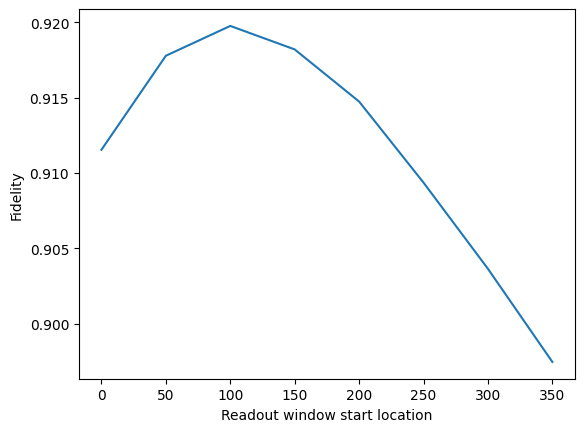

In [33]:
ml_fidelity = 1 - (1 - np.array(ml_e_accuracy)) - (1 - np.array(ml_g_accuracy)) 

plt.figure()
plt.plot(window_start_locations, ml_fidelity)
plt.xlabel('Readout window start location')
plt.ylabel('Fidelity')

print('Accuracy', ml_accuracy)
print('Fidelity', ml_fidelity)

### Single-Layer Model

<img src="../images/single_layer_model.png" alt="alt text" width="35%">

In [34]:
checkpoint_filename = 'single_layer_model_subwindow.h5'
callbacks = [
        ModelCheckpoint(
        checkpoint_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6),
]

model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(800,)))
model.add(BatchNormalization())

print(model.summary())

sl_accuracy, sl_e_accuracy, sl_g_accuracy = scan_readout_window(model, window_start_locations, window_size, callbacks)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 1602      
                                                                 
 batch_normalization_1 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
Total params: 1,610
Trainable params: 1,606
Non-trainable params: 4
_________________________________________________________________
None


Epoch 1/50
105/105 - 1s - loss: 0.7214 - accuracy: 0.5892 - val_loss: 0.6009 - val_accuracy: 0.6797 - lr: 1.0000e-04 - 1s/epoch - 14ms/step
Epoch 2/50
105/105 - 1s - loss: 0.5031 - accuracy: 0.7560 - val_loss: 0.4284 - val_accuracy: 0.8082 - lr: 1.0000e-04 - 887ms/epoch - 8ms/step
Epoch 3/50
105/105 - 1s - loss: 0.4006 - accuracy: 0.8473 - val_loss: 0.3510 - val_accuracy: 0.8722 - lr: 1.0000e-04 - 885ms/epoch - 8ms/step
Epoch 4/50
105/105 - 1s - loss: 0.3452 - accuracy: 0.8928 - val_loss: 0.3111 - val_accuracy: 0.9045 - lr: 1.0000e-04 - 901ms/epoch - 9ms/step
Epoch 5/50
105/105 - 1s - loss: 0.3122 - accuracy: 0.9160 - val_loss: 0.2878 - val_accuracy: 0.9220 - lr: 1.0000e-04 - 902ms/epoch - 9ms/step
Epoch 6/50
105/105 - 1s - loss: 0.2907 - accuracy: 0.9291 - val_loss: 0.2726 - val_accuracy: 0.9336 - lr: 1.0000e-04 - 873ms/epoch - 8ms/step
Epoch 7/50
105/105 - 1s - loss: 0.2757 - accuracy: 0.9372 - val_loss: 0.2619 - val_accuracy: 0.9395 - lr: 1.0000e-04 - 882ms/epoch - 8ms/step
Epoch 8/

Accuracy [0.9575, 0.95974, 0.95965, 0.95773, 0.9552, 0.95264, 0.94943, 0.94674]
Fidelity [0.915   0.91948 0.9193  0.91546 0.9104  0.90528 0.89886 0.89348]


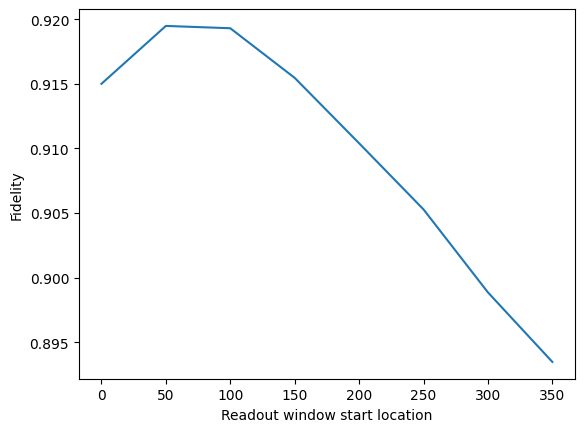

In [35]:
sl_fidelity = 1 - (1 - np.array(sl_e_accuracy)) - (1 - np.array(sl_g_accuracy)) 

plt.figure()
plt.plot(window_start_locations, sl_fidelity)
plt.xlabel('Readout window start location')
plt.ylabel('Fidelity')

print('Accuracy', sl_accuracy)
print('Fidelity', sl_fidelity)

Text(0, 0.5, 'Flidelity')

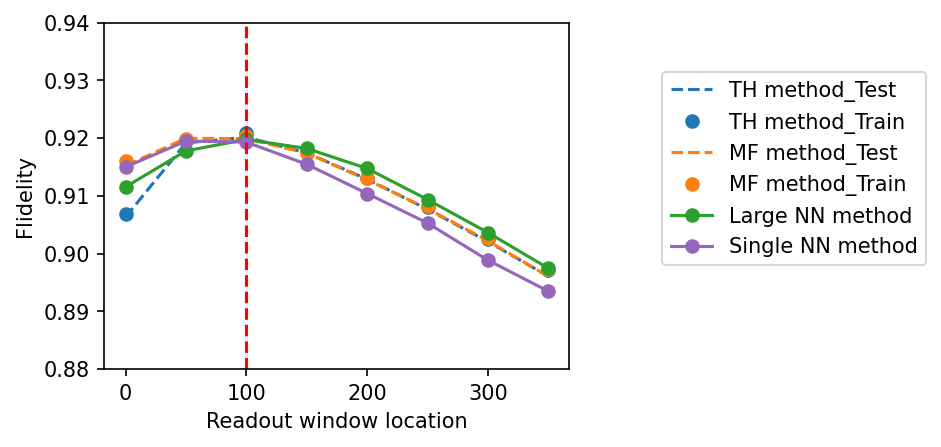

In [37]:
figure(figsize = (4,3), dpi = 150)
plot(readout_loc_list, all_fidelity, '--', color = 'C0', label = 'TH method_Test')
plot(readout_loc_list, all_fidelity_train, 'o', color = 'C0',label = 'TH method_Train')
plot(readout_loc_list, all_fidelity_MF_test, '--', color = 'C1', label = 'MF method_Test')
plot(readout_loc_list, all_fidelity_MF_train, 'o', color = 'C1', label = 'MF method_Train')
plot(readout_loc_list, np.array(ml_accuracy)*2-1, 'o-', color = 'C2', label = 'Large NN method')
plot(readout_loc_list, np.array(sl_accuracy)*2-1, 'o-', color = 'C4', label = 'Single NN method')

axvline(100, ls = '--', color = 'red')
legend(loc = (1.2,.3))
ylim(0.88,0.94)
xlabel('Readout window location')
ylabel('Flidelity')

In [39]:
outfile = '_FIG_EXP_train_window_loc_MF_TH_NN.npz'
note = 'Training data on 0528, readout fidelity with moving readout window, window size = 400'

np.savez(outfile, 
         readout_loc_list=readout_loc_list, 
         ml_accuracy = np.array(ml_accuracy)*2-1, 
         sl_accuracy = np.array(sl_accuracy)*2-1, 
         fidelity_TH_train = all_fidelity_train,
         fidelity_TH_test = all_fidelity,
         fidelity_MF_train = all_fidelity_MF_train,
         fidelity_MF_test = all_fidelity_MF_test,
         note=note)
